In [102]:
import numpy as np
import tensorflow
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [103]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [104]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [105]:
def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [106]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model, model_body

In [107]:
input_shape = (416,416)

classes = ["no_mask", "yes_mask"]

num_classes = 2

train_annotation_path = "train_text.txt"

eval_annotation_path = "eval_text.txt"

anchors_path = "anchors.txt"
anchors = get_anchors(anchors_path)

log_dir = 'logs/'

In [108]:
model, yolo_model = create_model(input_shape, anchors, num_classes,
    freeze_body=2, weights_path='model_data/default_weights.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


2022-11-18 15:50:38.154976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1512] Adding visible gpu devices: 0
2022-11-18 15:50:38.155058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:984] Device interconnect StreamExecutor with strength 1 edge matrix:
2022-11-18 15:50:38.155065: I tensorflow/core/common_runtime/gpu/gpu_device.cc:990]      0 
2022-11-18 15:50:38.155069: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1003] 0:   N 
2022-11-18 15:50:38.155182: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 15061 MB memory) -> physical GPU (device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:41:04.0, compute capability: 7.0)


Load weights model_data/default_weights.h5.
Freeze the first 249 layers of total 252 layers.


In [109]:
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True)
# reducing learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1)
# early_stopping for avoiding overfitting
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)
logging = TensorBoard(log_dir=log_dir)

In [110]:
with open(train_annotation_path) as f:
    train_lines = f.readlines()

In [111]:
with open(eval_annotation_path) as f:
    eval_lines = f.readlines()

In [11]:
model.compile(optimizer=Adam(lr=1e-3), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 4
model.fit_generator(data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, len(train_lines)//batch_size),
        validation_data=data_generator_wrapper(eval_lines, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, len(eval_lines)//batch_size),
        epochs=50,
        initial_epoch=0,
        callbacks=[checkpoint])
model.save_weights(log_dir + 'trained_weights_stage_1.h5')


Epoch 1/50


2022-11-18 14:08:47.402944: I tensorflow/stream_executor/dso_loader.cc:152] successfully opened CUDA library libcublas.so.10.0 locally


58/58 [==============================] - 48s 827ms/step - loss: 1712.3032 - val_loss: 198.1197
Epoch 2/50
58/58 [==============================] - 14s 238ms/step - loss: 152.4882 - val_loss: 103.5303
Epoch 3/50
58/58 [==============================] - 15s 253ms/step - loss: 100.1310 - val_loss: 82.1618
Epoch 4/50
58/58 [==============================] - 15s 255ms/step - loss: 74.5701 - val_loss: 64.0224
Epoch 5/50
58/58 [==============================] - 15s 250ms/step - loss: 63.8739 - val_loss: 58.2475
Epoch 6/50
58/58 [==============================] - 14s 244ms/step - loss: 56.2805 - val_loss: 49.3659
Epoch 7/50
58/58 [==============================] - 14s 236ms/step - loss: 49.9476 - val_loss: 50.8316
Epoch 8/50
58/58 [==============================] - 14s 246ms/step - loss: 46.4500 - val_loss: 40.8380
Epoch 9/50
58/58 [==============================] - 14s 235ms/step - loss: 43.9866 - val_loss: 43.3055
Epoch 10/50
58/58 [==============================] - 14s 248ms/step - loss: 42

In [12]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
    
model.compile(optimizer=Adam(lr=1e-4), loss={
    # use custom yolo_loss Lambda layer.
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 2
model.fit_generator(data_generator_wrapper(train_lines, batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, len(train_lines)//batch_size),
        validation_data=data_generator_wrapper(eval_lines, batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, len(eval_lines)//batch_size),
        epochs=150,
        initial_epoch=50,
        callbacks=[checkpoint, reduce_lr])
model.save_weights(log_dir + 'trained_weights_final.h5')


Epoch 51/150
116/116 [==============================] - 32s 279ms/step - loss: 26.4993 - val_loss: 23.6279
Epoch 52/150
116/116 [==============================] - 16s 140ms/step - loss: 23.3666 - val_loss: 22.9444
Epoch 53/150
116/116 [==============================] - 16s 138ms/step - loss: 21.7650 - val_loss: 20.4535
Epoch 54/150
116/116 [==============================] - 16s 140ms/step - loss: 20.7827 - val_loss: 20.4314
Epoch 55/150
116/116 [==============================] - 15s 129ms/step - loss: 20.6709 - val_loss: 22.7779
Epoch 56/150
116/116 [==============================] - 15s 127ms/step - loss: 20.8942 - val_loss: 836.4328
Epoch 57/150
116/116 [==============================] - 15s 131ms/step - loss: 20.1456 - val_loss: 18.8738
Epoch 58/150
116/116 [==============================] - 15s 128ms/step - loss: 20.1301 - val_loss: 21.5247
Epoch 59/150
116/116 [==============================] - 15s 127ms/step - loss: 19.4632 - val_loss: 20.2116
Epoch 60/150
116/116 [==============

In [14]:
test_annotation_path = "test_text.txt"

with open(test_annotation_path) as f:
    test_lines = f.readlines()

In [126]:
model.load_weights("logs/ep084-loss16.250-val_loss14.099.h5")

In [127]:
model.evaluate(data_generator_wrapper(test_lines, batch_size, input_shape, anchors, num_classes),
              steps=max(1, len(test_lines)//batch_size))

14/14 [==============================] - 2s 125ms/step - loss: 20.0035


20.003459112984793

In [128]:
from yolo3.model import yolo_body
from tensorflow.python.keras.layers import Input, Dense, Embedding
from tensorflow.keras.models import Model
anchor_path = "anchors.txt"
with open(anchor_path) as f:
    anchors = f.readline()
anchors = [float(x) for x in anchors.split(',')]
anchors = np.array(anchors).reshape(-1,2)
yolo_model = yolo_body(Input(shape=(None,None,3)),len(anchors)//3,num_classes)

In [129]:
weights_path="logs/ep084-loss16.250-val_loss14.099.h5"
yolo_model.load_weights(weights_path)

In [130]:
import os
test_img = [os.path.join("test/Images/", x) for x in os.listdir("./test/Images/")]
test_img_name = [x for x in os.listdir("./test/Images/")]

In [119]:
#code for generating test set detection result in txt
from PIL import Image
from yolo3.utils import letterbox_image
from yolo3.model import yolo_eval
    
for i, img in enumerate(test_img_name):
    print_buffer = []
    
    sess = K.get_session()
    
    iou=0.5
    score=0.5
    
    image = Image.open(test_img[i])
    image_ori = np.array(image)
    
    new_image_size = (image.width - (image.width % 32), image.height - (image.height % 32))
    boxed_image = letterbox_image(image, new_image_size)
    image_data = np.array(boxed_image, dtype='float32')
    image_data /= 255
    image_data = np.expand_dims(image_data, 0)
    
    input_image_shape = K.placeholder(shape=(2, ))

    boxes, scores, classes = yolo_eval(
        yolo_model.output,
        anchors,
        num_classes,
        input_image_shape,
        score_threshold=score,
        iou_threshold=iou)
    
    out_boxes, out_scores, out_classes = sess.run(
    [boxes, scores, classes],
    feed_dict={
        yolo_model.input: image_data,
        input_image_shape: [image.size[1], image.size[0]],
        K.learning_phase(): 0
    })
    
    classes = ["no_mask", "yes_mask"]
    
    class_coco = classes
    out_coco=[]
    for j in out_classes:
        out_coco.append(class_coco[j])
    
    for k, out_box in enumerate(out_boxes):
        xmin, ymin, xmax, ymax = out_box[1], out_box[0], out_box[3], out_box[2]
        confidence_score = out_scores[k]
        class_name = out_coco[k]

        new_str = "{} {} {} {} {} {}".format(class_name, confidence_score, xmin, ymin, xmax, ymax)
        
        print_buffer.append(new_str)
        
    with open("input/detection-results/{}".format(img.replace("jpg", "txt").replace("png", "txt")), "w") as f:
        pass
        
    with open("input/detection-results/{}".format(img.replace("jpg", "txt").replace("png", "txt")), "a") as f:
        f.write("\n".join(print_buffer))

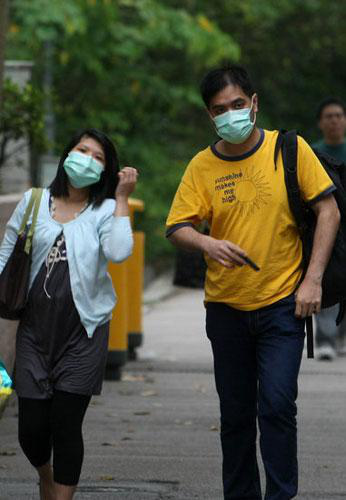

In [131]:
image_path = "test/Images/d072_1580791027546.jpg"
image = Image.open(image_path)
image

yes_mask 0.896349 (61, 124) (118, 194)
yes_mask 0.968722 (196, 64) (261, 148)


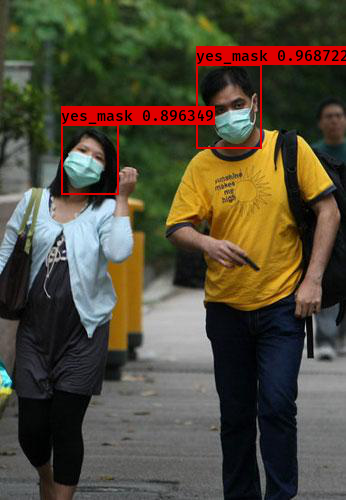

In [132]:
#inference on image path
image_path = "test/Images/d072_1580791027546.jpg"

sess = K.get_session()

iou=0.5
score=0.5
image = Image.open(image_path)
image_ori = np.array(image)

new_image_size = (image.width - (image.width % 32), image.height - (image.height % 32))
boxed_image = letterbox_image(image, new_image_size)
image_data = np.array(boxed_image, dtype='float32')
image_data /= 255
image_data = np.expand_dims(image_data, 0)

input_image_shape = K.placeholder(shape=(2,))

boxes, scores, classes = yolo_eval(
    yolo_model.output,
    anchors,
    num_classes,
    input_image_shape,
    score_threshold=score,
    iou_threshold=iou
)

out_boxes, out_scores, out_classes = sess.run(
[boxes, scores, classes],
feed_dict={
    yolo_model.input: image_data,
    input_image_shape: [image.size[1], image.size[0]],
    K.learning_phase(): 0
})

classes = ["no_mask", "yes_mask"]

class_coco = classes
out_coco=[]
for i in out_classes:
    out_coco.append(class_coco[i])
    
font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
                      size=np.floor(3e-2*image.size[1]+0.5).astype('int32'))

thickness = (image.size[0]+image.size[1])//300

for i,c in reversed(list(enumerate(out_coco))):
    predicted_class = c
    box = out_boxes[i]
    score=out_scores[i]

    label = '{} {:2f}'.format(predicted_class, score)
    draw=ImageDraw.Draw(image)
    label_size=draw.textsize(label,font)

    top, left, bottom, right = box
    top = max(0, np.floor(top+0.5).astype('int32'))
    left = max(0, np.floor(left+0.5).astype('int32'))
    bottom=min(image.size[1], np.floor(bottom+0.5).astype('int32'))
    right=min(image.size[1], np.floor(right+0.5).astype('int32'))    
    print(label, (left, top), (right, bottom))

    if top - label_size[1] >=0:
        text_origin = np.array([left,top-label_size[1]])
    else:
        text_origin = np.array([left, top + 1])

    for i in range(thickness):
        draw.rectangle(
            [left+i, top+i, right-i, bottom-i],
            outline=225)
    draw.rectangle(
        [tuple(text_origin),tuple(text_origin+label_size)],
        fill=225)
    draw.text(text_origin,label, fill=(0,0,0), font=font)
    del draw

image

In [ ]:
!python mAP.py

In [ ]:
import re

index = [-1, -2, -5, -6]

with open("output/output.txt", "r") as f:
    lines = f.readlines()
    
    li = []
    
    for i in index:
        a = lines[i]
        matches = re.search(r"tp:(.[0-9]?), fp:(.[0-9]?)", a)
        if matches:
            li.append(matches.groups())
        else:
            li.append(lines[i].split(" ")[1].strip())

In [92]:
yes_mask_tp = int(li[0][0])
yes_mask_fp = int(li[0][1])

no_mask_tp = int(li[1][0])
no_mask_fp = int(li[1][1])

yes_mask_truth_total = int(li[2])
no_mask_truth_total = int(li[3])

no_mask_diff = no_mask_truth_total - (no_mask_tp + no_mask_fp)
yes_mask_diff = yes_mask_truth_total - (yes_mask_tp + yes_mask_fp)

no_mask_fp += no_mask_diff
yes_mask_fp += yes_mask_diff

In [95]:
#create and save the confusion matrix to a png format
import seaborn
import matplotlib.pyplot as plt
 
 
def plot_confusion_matrix(data, labels, output_filename):
    """Plot confusion matrix using heatmap.
 
    Args:
        data (list of list): List of lists with confusion matrix data.
        labels (list): Labels which will be plotted across x and y axis.
        output_filename (str): Path to output file.
 
    """
    seaborn.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
 
    plt.title("Confusion Matrix")
 
    seaborn.set(font_scale=1.4)
    ax = seaborn.heatmap(data, annot=True, cmap="YlGnBu", cbar_kws={'label': 'Scale'})
 
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
 
    ax.set(ylabel="True Label", xlabel="Predicted Label")
 
    plt.savefig(output_filename, bbox_inches='tight', dpi=300)
    plt.close()
 
# define data
data = [[no_mask_tp, no_mask_fp],
        [yes_mask_fp, yes_mask_tp]]
 
# define labels
labels = ["no_mask", "yes_mask"]
 
# create confusion matrix
plot_confusion_matrix(data, labels, "confusion_matrix.png")
